In [1]:
# Parameters
name = "O_III-5007_mask_bin_4"


In [2]:
# Parameters
#name = "H_I-6563_mask_bin_4"

In [3]:
import time
start_time=time.time()
import sys
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sys.path.append(r"C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\py_modules")
sys.path.append(r"C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse")

# Add path to py_modules 
#sys.path.append(str(Path().resolve().parents[0] / 'py_modules')) # 1 level up = project root

# Add path to pipeline_config.py
#sys.path.append(str(Path().resolve().parents[0]))  # 1 level up = project root

# Import from pipeline_config and py_modules
from pipeline_config import MAPS_DIR

import strucfunc
from strucfunc import sosflog
#import bfunc

In [5]:
# This should have been generated by notebook_template_mask
input_path = MAPS_DIR / f"{name}.json"

with open(input_path) as f:
    obs_data = json.load(f)

In [6]:
# obs_data['name']
pc = obs_data['pc']
s0 = obs_data['s0']
pix = obs_data['pix']
box_size = obs_data['box_size']
sb = np.array(obs_data['sb'])
vv = np.array(obs_data['vv'])

In [7]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

good = (~m) & (sb > 0.001)

In [8]:
rslt = strucfunc.strucfunc_numba_parallel(vv, wmap=sb, dlogr=0.05)

C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\py_modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\py_modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in divide
  'Weighted B(r)': wsf/weight}


In [9]:
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [10]:
b2    = rslt['Unweighted B(r)'] 
e_b2  = b2  *.1

b2w   = rslt['Weighted B(r)']
e_b2w = b2w  *.1

s     = 10**rslt['log10 r'] * pix * pc
e_s   = s  *.1

sig2  = rslt['Unweighted sigma^2']
sig   = sig2**0.5

sig2w = rslt['Weighted sigma^2']


In [11]:
#x_linear = s[5:int(len(s)/2)]
#y_linear = b2[5:int(len(s)/2)]

#m, c = np.polyfit(x_linear, y_linear, 1)
#r0 = np.interp(sig2, b2, s,period = 360)

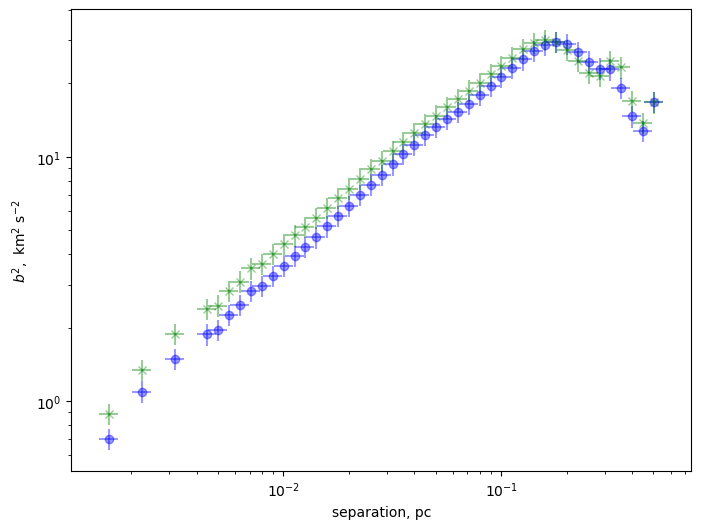

In [12]:
#m = 1.2
#noise = 0.01
#rgrid = np.logspace(-3, .1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.4,color="blue")
ax.errorbar(s, b2w, yerr=e_b2w, xerr=e_s, fmt='x', alpha=0.4,color="green")

ax.set(xscale='log', yscale='log', 
       xlabel='separation, pc',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None
#sig2, r0, m

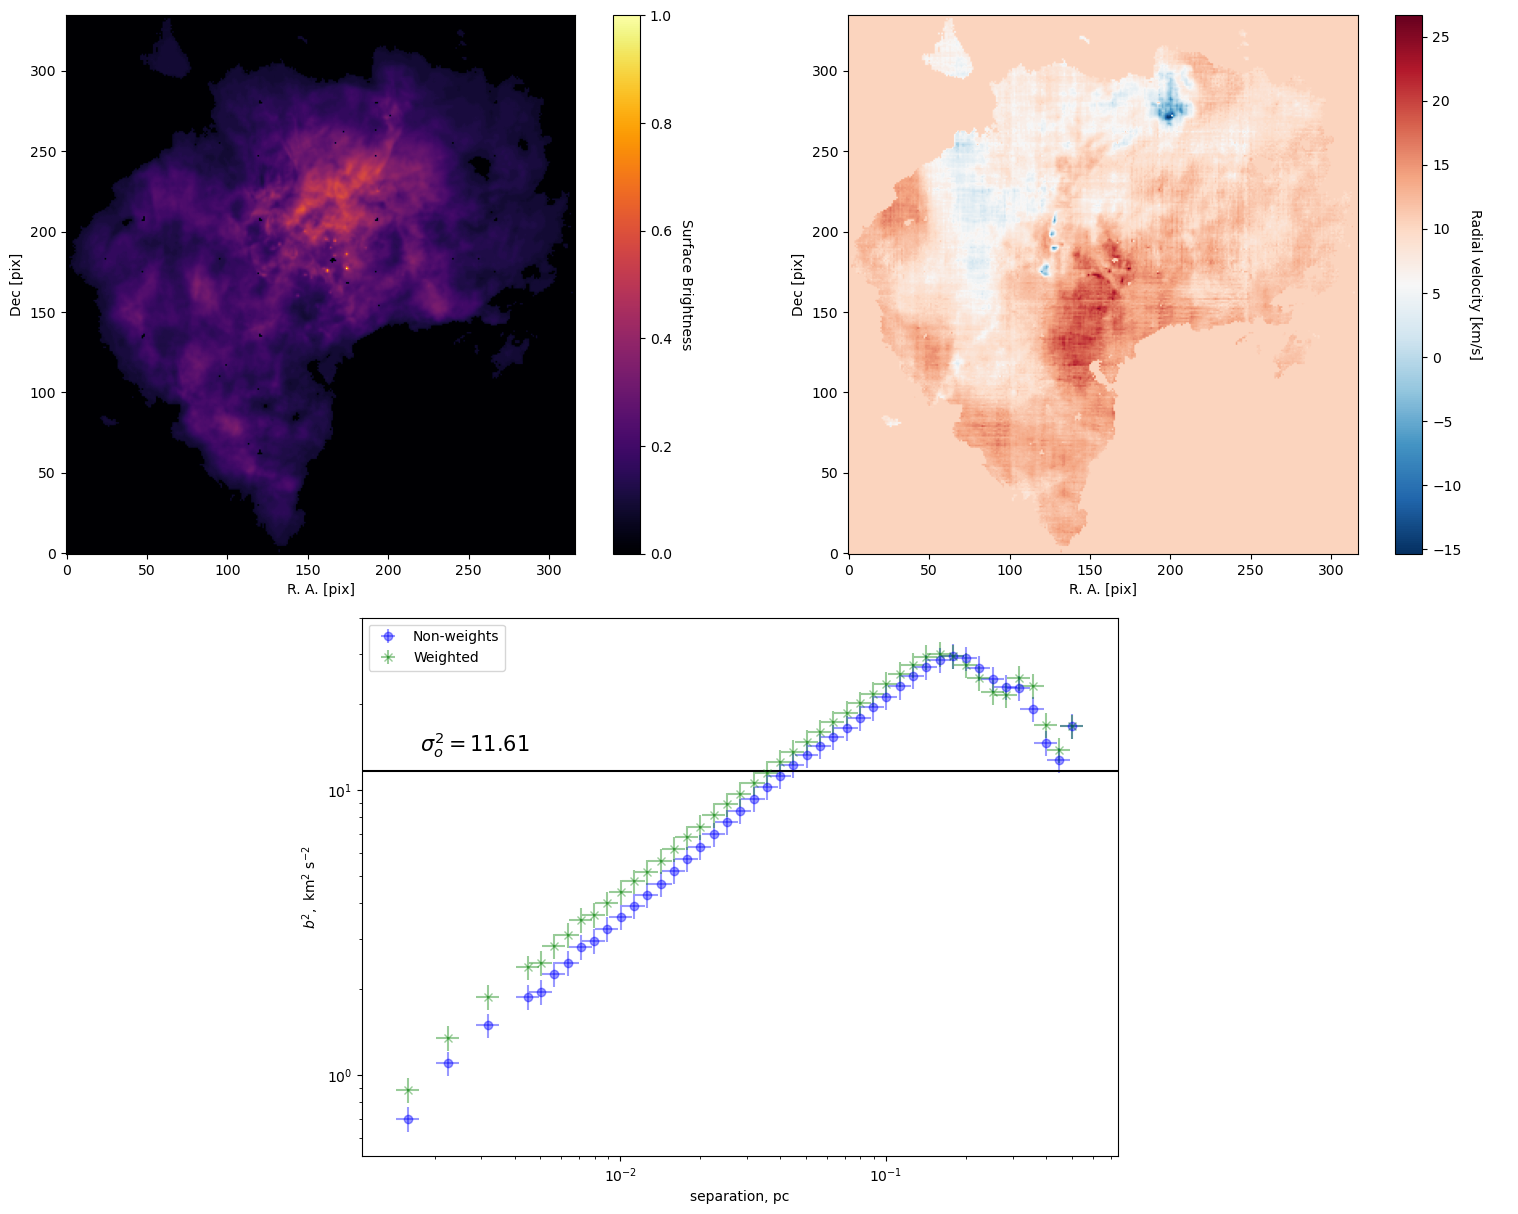

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Top-Left: Surface Brightness
im0 = axs[0, 0].imshow(sb, cmap='inferno')
cbar0 = fig.colorbar(im0, ax=axs[0, 0])
cbar0.set_label('Surface Brightness', rotation=270, labelpad=15)
axs[0, 0].set_xlabel('R. A. [pix]')
axs[0, 0].set_ylabel('Dec [pix]')
axs[0, 0].invert_yaxis()

# Top-Right: Radial Velocity
im1 = axs[0, 1].imshow(vv, cmap='RdBu_r')
cbar1 = fig.colorbar(im1, ax=axs[0, 1])
cbar1.set_label('Radial velocity [km/s]', rotation=270, labelpad=15)
axs[0, 1].set_xlabel('R. A. [pix]')
axs[0, 1].set_ylabel('Dec [pix]')
axs[0, 1].invert_yaxis()

# Bottom-Right: turn off
axs[1, 1].axis('off')

# Bottom-Left: errorbar plot (center it)
# Do this BEFORE tight_layout so we avoid its override
fig.tight_layout()
pos = axs[1, 0].get_position()
new_x = (pos.x0 + axs[1, 1].get_position().x1) / 2 - pos.width / 2
axs[1, 0].set_position([new_x, pos.y0, pos.width, pos.height])

# Now plot
axs[1, 0].errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.4, color="blue", label='Non-weights')
axs[1, 0].errorbar(s, b2w, yerr=e_b2w, xerr=e_s, fmt='x', alpha=0.4, color="green", label='Weighted')

# Plot horizontal line at sig2
axs[1, 0].axhline(sig2, color='black', linestyle='-')

# Add text label near the line (adjust position as needed)
axs[1, 0].text(s[5], sig2 * 1.1, f"$\\sigma^2_o = {sig2:.2f}$", fontsize = 15, color='black', ha='center', va='bottom')


axs[1, 0].set(xscale='log', yscale='log',
              xlabel='separation, pc',
              ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$')
axs[1, 0].legend()

plt.show()



In [14]:
data_export = {   
       'name'     : name, 
        'pc'      : pc,
        's0'      : s0,    
        'pix'     : pix,
        'box_size': box_size,
        'sig2'    : sig2,
        's'       : s,
        'b2'      : b2,
        'SF'      : rslt,
        'sb'      : sb,
        'vv'      : vv,
}

data_export

{'name': 'O_III-5007_mask_bin_4',
 'pc': 0.0019877360925490972,
 's0': 0.0007596443665792729,
 'pix': 0.8,
 'box_size': 0.5182039811409099,
 'sig2': 11.6069471967576,
 's': array([0.00159019, 0.00178422, 0.00200193, 0.0022462 , 0.00252028,
        0.0028278 , 0.00317284, 0.00355999, 0.00399437, 0.00448176,
        0.00502862, 0.0056422 , 0.00633066, 0.00710311, 0.00796982,
        0.00894229, 0.01003341, 0.01125768, 0.01263132, 0.01417257,
        0.01590189, 0.01784221, 0.02001929, 0.02246201, 0.0252028 ,
        0.028278  , 0.03172844, 0.03559989, 0.03994374, 0.04481761,
        0.05028619, 0.05642203, 0.06330656, 0.07103113, 0.07969824,
        0.08942289, 0.10033413, 0.11257675, 0.12631319, 0.14172573,
        0.15901889, 0.17842213, 0.20019292, 0.22462015, 0.25202795,
        0.28278001, 0.31728439, 0.35599894, 0.39943739, 0.44817612,
        0.50286188, 0.5642203 , 0.63306559]),
 'b2': array([ 0.70031684,         nan,         nan,  1.09475804,         nan,
                nan,  1

In [15]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [16]:
jsonfilename = name + ".json"
with open(jsonfilename, "w") as f:
    json.dump(data_export, fp=f, indent=3, cls=MyEncoder)

In [17]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 50.62902641296387 seconds ---
